# Data Preparation for EMNIST Letters Dataset

## Load the Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../emnist-letters-train.csv')

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


## Understanding the Data Structure

Unique labels: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]


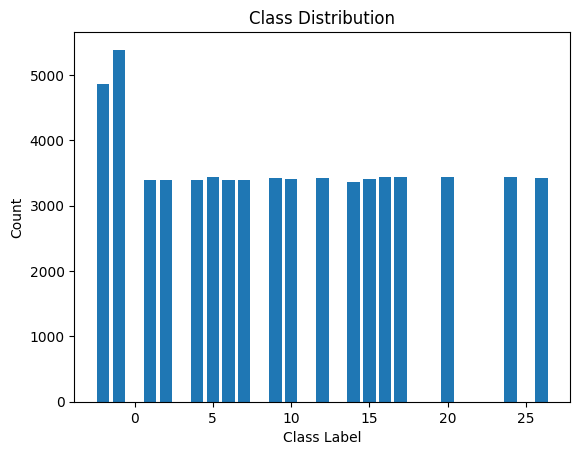

Unique labels before cleaning: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts before cleaning: [4856 5384 3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430
 3435 3436 3436 3427]
Total images before cleaning: 64828
Corresponding letters: ['>', '?', 'A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [2]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels: {unique_labels}")

# Visualize class distribution
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels before cleaning: {unique_labels}")
print(f"Label counts before cleaning: {counts}")
print(f"Total images before cleaning: {len(pixels)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels]}")

In [3]:
# Reshape and normalize
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = images / 255.0  # Normalize to [0, 1]

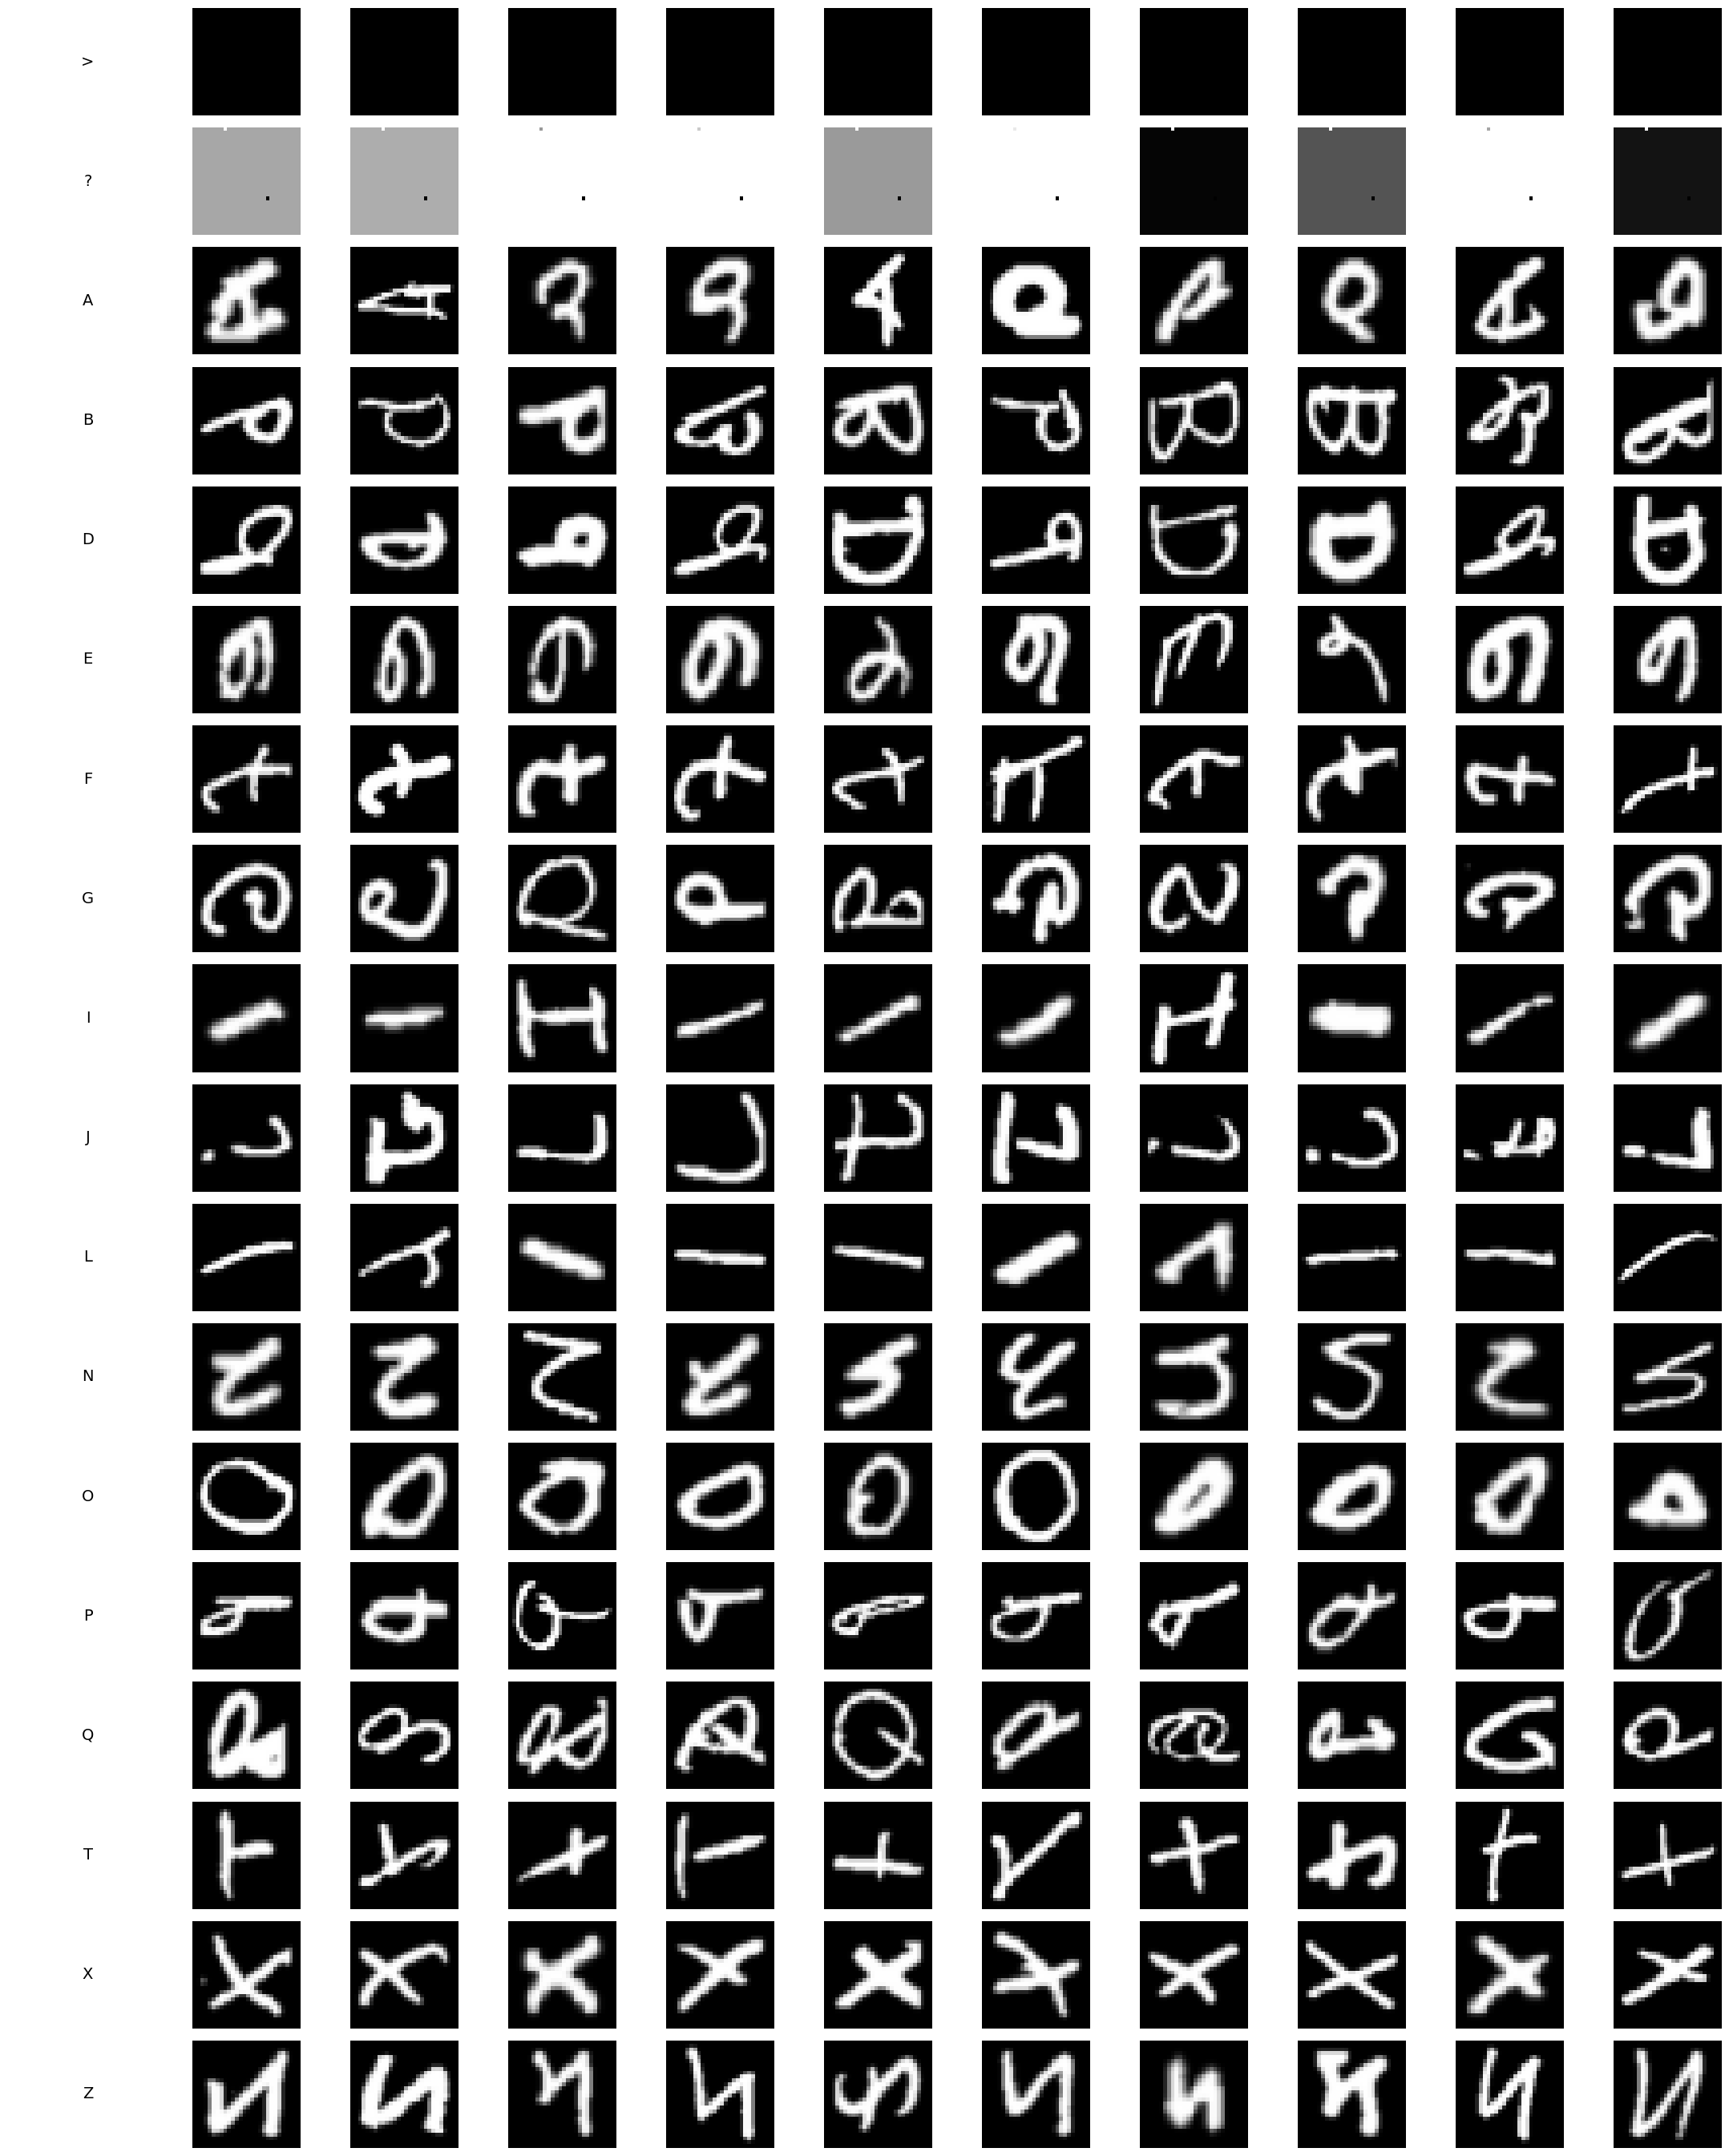

In [4]:
# Get all unique class labels
unique_labels_to_show = np.sort(np.unique(labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Cleaning

In [5]:
# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

In [6]:
# Rotate and flip the images to upright position
from skimage.transform import rotate

# Rotate 90 degrees clockwise (use -90 degrees)
# Then mirror (flip) horizontally with np.fliplr
final_images = np.array([
    np.fliplr(rotate(img.squeeze(), -90, resize=False, mode='edge'))
    for img in final_images
])

# Ensure final_images has the correct shape
final_images = final_images[..., np.newaxis]

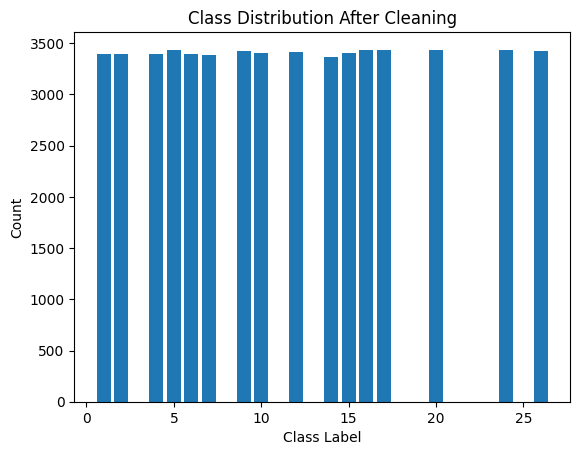

Unique labels after cleaning: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts after cleaning: [3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430 3435 3436
 3436 3427]
Total images after cleaning: 54588
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [7]:
# Show class distribution after cleaning
unique_labels_cleaned, counts_cleaned = np.unique(final_labels, return_counts=True)
plt.bar(unique_labels_cleaned, counts_cleaned)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels after cleaning: {unique_labels_cleaned}")
print(f"Label counts after cleaning: {counts_cleaned}")
print(f"Total images after cleaning: {len(final_images)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels_cleaned]}")


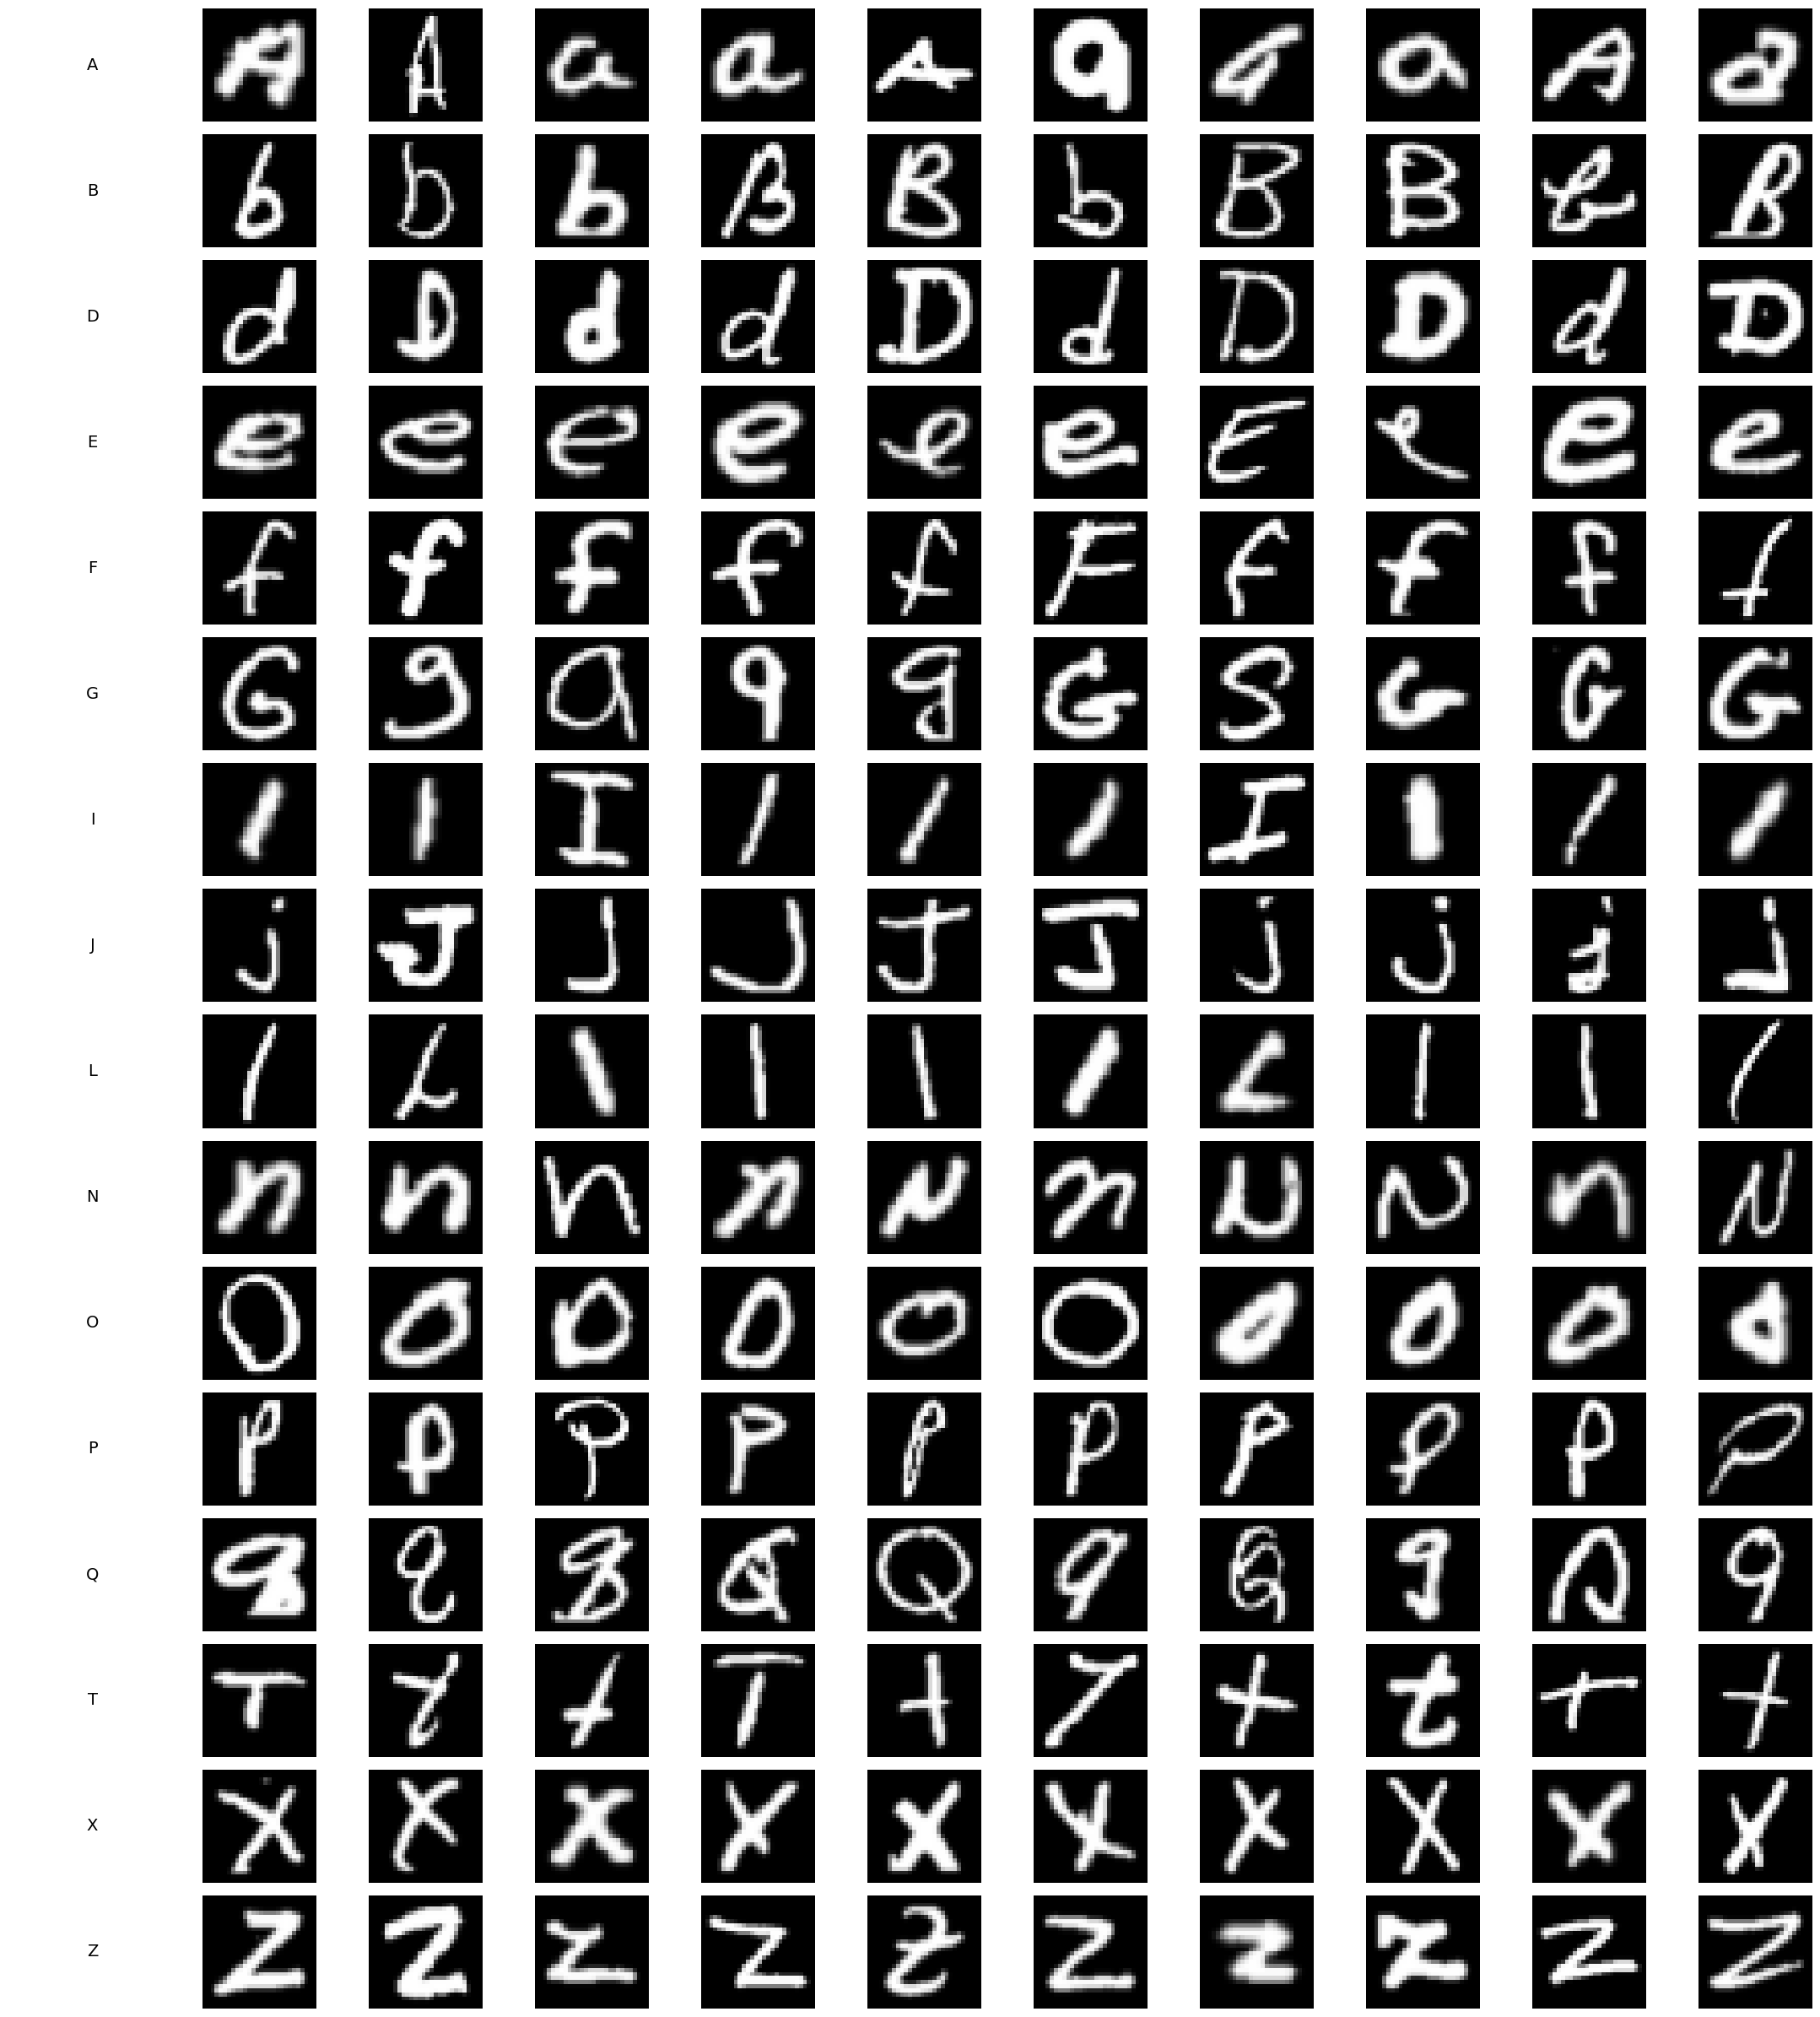

In [8]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Preparation

In [9]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding (for 16 classes)
selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

# Convert letters to their label values (A=1, B=2, ..., Z=26)
selected_labels = [ord(c) - 64 for c in selected_letters]

# Now convert to 0-15 range for one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(selected_labels)}
mapped_labels = np.array([label_mapping[label] for label in final_labels])  # FIXED: Use final_labels not filtered_labels

# One-hot encode (now safe with 16 classes)
one_hot_labels = to_categorical(mapped_labels, num_classes=16)

In [10]:
# Verify the mapping is correct
print("Label mapping verification:")
for i in range(len(selected_letters)):
    letter = selected_letters[i]
    original_label = selected_labels[i]  # EMNIST label (1-26)
    mapped_label = i  # GAN label (0-15)
    print(f"Letter {letter}: EMNIST label {original_label} -> GAN label {mapped_label}")

print(f"\nMapped labels shape: {mapped_labels.shape}")
print(f"Mapped labels range: {mapped_labels.min()} to {mapped_labels.max()}")
print(f"Unique mapped labels: {np.unique(mapped_labels)}")

Label mapping verification:
Letter A: EMNIST label 1 -> GAN label 0
Letter B: EMNIST label 2 -> GAN label 1
Letter D: EMNIST label 4 -> GAN label 2
Letter E: EMNIST label 5 -> GAN label 3
Letter F: EMNIST label 6 -> GAN label 4
Letter G: EMNIST label 7 -> GAN label 5
Letter I: EMNIST label 9 -> GAN label 6
Letter J: EMNIST label 10 -> GAN label 7
Letter L: EMNIST label 12 -> GAN label 8
Letter N: EMNIST label 14 -> GAN label 9
Letter O: EMNIST label 15 -> GAN label 10
Letter P: EMNIST label 16 -> GAN label 11
Letter Q: EMNIST label 17 -> GAN label 12
Letter T: EMNIST label 20 -> GAN label 13
Letter X: EMNIST label 24 -> GAN label 14
Letter Z: EMNIST label 26 -> GAN label 15

Mapped labels shape: (54588,)
Mapped labels range: 0 to 15
Unique mapped labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


## Data Verification 

In [11]:
# Check Basic Shapes & Types
print("Total samples:", len(final_images))
print("Image shape:", final_images.shape[1:])
print("Labels shape:", one_hot_labels.shape)
print("Image dtype:", final_images.dtype)
print("Label dtype:", one_hot_labels.dtype)


Total samples: 54588
Image shape: (28, 28, 1)
Labels shape: (54588, 16)
Image dtype: float32
Label dtype: float32


In [12]:
# Check pixel value range
print("Pixel value range:", final_images.min(), "to", final_images.max())

Pixel value range: 0.0 to 1.0


In [13]:
# Check label classes and distribution
# If labels are one-hot encoded, convert back to class indices
labels_int = np.argmax(one_hot_labels, axis=1)

print("Label classes in dataset:", np.unique(labels_int))
print("Label distribution:")
unique, counts = np.unique(labels_int, return_counts=True)
print(dict(zip(unique, counts)))


Label classes in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label distribution:
{0: 3396, 1: 3396, 2: 3398, 3: 3437, 4: 3394, 5: 3385, 6: 3428, 7: 3402, 8: 3415, 9: 3365, 10: 3408, 11: 3430, 12: 3435, 13: 3436, 14: 3436, 15: 3427}


In [14]:
print("Labels shape:", labels.shape)
print("Labels example:", labels[0])

# Check if labels look like one-hot vectors
if len(labels.shape) == 2 and labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")


Labels shape: (64828,)
Labels example: -2
Likely integer labels


In [15]:
print("Labels shape:", mapped_labels.shape)
print("Labels example:", mapped_labels[0])

# Check if labels look like one-hot vectors
if len(mapped_labels.shape) == 2 and mapped_labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(mapped_labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")

Labels shape: (54588,)
Labels example: 10
Likely integer labels


# Base DCGAN Model

## Model Building

In [16]:
# Simple DCGAN base model (no label conditioning)
dcgan_latent_dim = 100

def build_dcgan_generator(latent_dim=100):
  model = models.Sequential(name='dcgan_generator')
  model.add(layers.Dense(7*7*128, use_bias=False, input_dim=latent_dim))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Reshape((7, 7, 128)))
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid'))
  return model

def build_dcgan_discriminator(img_shape=(28,28,1)):
  model = models.Sequential(name='dcgan_discriminator')
  model.add(layers.Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=img_shape))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

# Build models
dcgan_generator = build_dcgan_generator(dcgan_latent_dim)
dcgan_discriminator = build_dcgan_discriminator(img_shape=(28,28,1))

dcgan_discriminator.compile(
  optimizer=optimizers.Adam(0.0002, 0.5),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# Combined DCGAN
dcgan_discriminator.trainable = False
dcgan_noise = layers.Input(shape=(dcgan_latent_dim,))
dcgan_img = dcgan_generator(dcgan_noise)
dcgan_validity = dcgan_discriminator(dcgan_img)
dcgan = models.Model(dcgan_noise, dcgan_validity)
dcgan.compile(
  optimizer=optimizers.Adam(0.0002, 0.5),
  loss='binary_crossentropy'
)

## Model Training

In [17]:
def train_dcgan(epochs, batch_size=64, sample_interval=250, X_train=None, save_dir=None):
  print(f"Starting DCGAN training for {epochs} epochs...")
  print(f"Training data shape: {X_train.shape}")
  print(f"Batch size: {batch_size}, Sample interval: {sample_interval}")

  # Adversarial ground truths
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, dcgan_latent_dim))
    gen_imgs = dcgan_generator.predict(noise, verbose=0)

    d_loss_real = dcgan_discriminator.train_on_batch(imgs, valid)
    d_loss_fake = dcgan_discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, dcgan_latent_dim))
    g_loss = dcgan.train_on_batch(noise, valid)

    # Print progress and sample images
    if epoch % sample_interval == 0:
      print(f"Epoch {epoch:4d} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
      if save_dir is not None:
        sample_dcgan_images(epoch, save_dir=save_dir)

  # Save weights
  print("Training completed! Saving model weights...")
  dcgan_generator.save_weights('dcgan_generator.weights.h5')
  dcgan_discriminator.save_weights('dcgan_discriminator.weights.h5')
  print("Weights saved successfully!")

def sample_dcgan_images(epoch, save_dir=None):
  if save_dir is None:
    return
  r, c = 4, 8  # 32 samples
  noise = np.random.normal(0, 1, (r * c, dcgan_latent_dim))
  gen_imgs = dcgan_generator.predict(noise, verbose=0)
  fig, axs = plt.subplots(r, c, figsize=(c * 1.5, r * 1.5))
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[i * c + j, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
  plt.tight_layout(pad=0.2)
  os.makedirs(save_dir, exist_ok=True)
  plt.savefig(f"{save_dir}/epoch_{epoch}.png", bbox_inches='tight', dpi=120, pad_inches=0.01)
  plt.close()

# Train DCGAN model on final_images
train_dcgan(
  epochs=5001,
  batch_size=64,
  sample_interval=100,
  X_train=final_images,
  save_dir="dcgan_images_samples"
)

Starting DCGAN training for 5001 epochs...
Training data shape: (54588, 28, 28, 1)
Batch size: 64, Sample interval: 100
Epoch    0 [D loss: 0.7099, acc.: 34.38%] [G loss: 0.6848]
Epoch    0 [D loss: 0.7099, acc.: 34.38%] [G loss: 0.6848]
Epoch  100 [D loss: 0.1259, acc.: 99.22%] [G loss: 0.3732]
Epoch  100 [D loss: 0.1259, acc.: 99.22%] [G loss: 0.3732]
Epoch  200 [D loss: 0.0570, acc.: 100.00%] [G loss: 0.3166]
Epoch  200 [D loss: 0.0570, acc.: 100.00%] [G loss: 0.3166]
Epoch  300 [D loss: 0.0892, acc.: 98.44%] [G loss: 0.1548]
Epoch  300 [D loss: 0.0892, acc.: 98.44%] [G loss: 0.1548]
Epoch  400 [D loss: 0.2515, acc.: 89.84%] [G loss: 0.0670]
Epoch  400 [D loss: 0.2515, acc.: 89.84%] [G loss: 0.0670]
Epoch  500 [D loss: 0.5963, acc.: 71.09%] [G loss: 1.6362]
Epoch  500 [D loss: 0.5963, acc.: 71.09%] [G loss: 1.6362]
Epoch  600 [D loss: 0.8881, acc.: 42.97%] [G loss: 1.1305]
Epoch  600 [D loss: 0.8881, acc.: 42.97%] [G loss: 1.1305]
Epoch  700 [D loss: 0.7547, acc.: 52.34%] [G loss: 0

# Base CGAN Model

## Model Building

In [ ]:
def build_generator(latent_dim=100, num_classes=16):
    # Conditional input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    
    # Combined input
    combined = layers.Concatenate()([noise_input, label_embedding])
    
    # Generator network
    x = layers.Dense(7*7*256, use_bias=False)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid')(x)
    
    return models.Model([noise_input, label_input], x, name='generator')

def build_discriminator(img_shape=(28,28,1), num_classes=16):
    # Image input
    img_input = layers.Input(shape=img_shape)
    
    # Label input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(np.prod(img_shape))(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)
    
    # Combined input
    combined = layers.Concatenate()([img_input, label_embedding])
    
    # Discriminator network
    x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(combined)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model([img_input, label_input], x, name='discriminator')

# Build and compile
latent_dim = 100
img_shape = (28,28,1)
num_classes = 16

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)

discriminator.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Combined GAN
discriminator.trainable = False
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([noise, label])
validity = discriminator([img, label])
gan = models.Model([noise, label], validity)
gan.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy'
)

## Model Training

In [ ]:
def train_gan(epochs, batch_size=128, sample_interval=50, X_train=None, y_train=None, save_dir=None, model_type='base'):
    print(f"Starting GAN training for {epochs} epochs...")
    print(f"Training data shape: {X_train.shape}")
    print(f"Batch size: {batch_size}, Sample interval: {sample_interval}")
    
    # Load and normalize data
    X_train, y_train = X_train, y_train  # From your data prep
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels.reshape(-1,1)], verbose=0)
        
        d_loss_real = discriminator.train_on_batch([imgs, labels.reshape(-1,1)], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels.reshape(-1,1)], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, valid_labels.reshape(-1,1)], valid)
        
        # Print progress and sample images (only once per interval)
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch:4d} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch, save_dir=save_dir)
    
    # Save weights
    print("Training completed! Saving model weights...")
    generator.save_weights(f'{model_type}_generator.weights.h5')
    discriminator.save_weights(f'{model_type}_discriminator.weights.h5')
    print("Weights saved successfully!")

def sample_images(epoch, save_dir=None):
    """Generate and save sample images for monitoring training progress"""
    if save_dir is None:
        return
        
    num_samples = 3  # Only 3 samples per class
    num_classes = len(selected_letters)
    nrows = num_samples + 1  # 1 for label, rest for images
    ncols = num_classes

    fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))

    noise = np.random.normal(0, 1, (num_classes * num_samples, latent_dim))
    sampled_labels = np.repeat(np.arange(num_classes), num_samples).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels], verbose=0)
    # No rescaling needed since generator outputs [0,1] directly

    for class_idx in range(num_classes):
        # First row: show label
        axs[0, class_idx].text(0.5, 0.5, selected_letters[class_idx], fontsize=16, ha='center', va='center')
        axs[0, class_idx].set_xticks([])
        axs[0, class_idx].set_yticks([])
        axs[0, class_idx].set_frame_on(False)

        # Next rows: show generated images
        for sample_idx in range(num_samples):
            img_idx = class_idx * num_samples + sample_idx
            axs[sample_idx + 1, class_idx].imshow(gen_imgs[img_idx, :, :, 0], cmap='gray', aspect='equal')
            axs[sample_idx + 1, class_idx].set_xticks([])
            axs[sample_idx + 1, class_idx].set_yticks([])
            axs[sample_idx + 1, class_idx].set_frame_on(False)

    plt.tight_layout(pad=0.2)
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/epoch_{epoch}.png", bbox_inches='tight', dpi=120, pad_inches=0.01)
    plt.close()  # Important: close the figure to free memory

In [ ]:
# Check if training data is ready
print("Training data summary:")
print(f"Images shape: {final_images.shape}")
print(f"Labels shape: {mapped_labels.shape}")
print(f"Image pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")
print(f"Unique labels: {np.unique(mapped_labels)}")

# Train the base model
train_gan(
    epochs=10001, 
    batch_size=64, 
    sample_interval=250, 
    X_train=final_images, 
    y_train=mapped_labels, 
    save_dir="base_images_samples", 
    model_type='base'
)

In [ ]:
def submission_images(file_name, save_dir=None):
    """Generate and save 160 images for submission"""
    if save_dir is None:
        return
        
    num_samples = 10  # 10 samples per class
    num_classes = len(selected_letters)
    nrows = num_samples + 1  # 1 for label, rest for images
    ncols = num_classes

    fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))

    noise = np.random.normal(0, 1, (num_classes * num_samples, latent_dim))
    sampled_labels = np.repeat(np.arange(num_classes), num_samples).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels], verbose=0)
    # No rescaling needed since generator outputs [0,1] directly

    for class_idx in range(num_classes):
        # First row: show label
        axs[0, class_idx].text(0.5, 0.5, selected_letters[class_idx], fontsize=16, ha='center', va='center')
        axs[0, class_idx].set_xticks([])
        axs[0, class_idx].set_yticks([])
        axs[0, class_idx].set_frame_on(False)

        # Next rows: show generated images
        for sample_idx in range(num_samples):
            img_idx = class_idx * num_samples + sample_idx
            axs[sample_idx + 1, class_idx].imshow(gen_imgs[img_idx, :, :, 0], cmap='gray', aspect='equal')
            axs[sample_idx + 1, class_idx].set_xticks([])
            axs[sample_idx + 1, class_idx].set_yticks([])
            axs[sample_idx + 1, class_idx].set_frame_on(False)

    plt.tight_layout(pad=0.2)
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{file_name}.png", bbox_inches='tight', dpi=120, pad_inches=0.01)
    plt.close()  # Important: close the figure to free memory

In [ ]:
# Generate 160 images for the base model
submission_images(file_name='base_160_images')

# EMNIST Classifier Model to Seperate Upper and Lower Case Images

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./EMNIST Classifier/emnist_letter_classifier.h5')

In [ ]:
# Predict letters for all images in final_images using the trained model
pred_probs = model.predict(final_images, batch_size=128, verbose=1)
predicted_labels = np.argmax(pred_probs, axis=1)

# Map numeric labels to characters using the SAME mapping as training
# Training uses: 0-25 for A-Z, 26-51 for a-z
def model_label_to_char(label):
    if label < 26:
        return chr(label + ord('A'))  # 0='A', 1='B', ..., 25='Z'
    else:
        return chr(label - 26 + ord('a'))  # 26='a', 27='b', ..., 51='z'

# Map EMNIST CSV labels to characters (for ground truth)
def csv_label_to_char(label):
    return chr(label + 64)  # EMNIST Letters: 1='A', 2='B', ..., 26='Z'

# Example: show predictions for the first 10 samples
for i in range(10):
    true_char = csv_label_to_char(final_labels[i])
    pred_char = model_label_to_char(predicted_labels[i])
    confidence = np.max(pred_probs[i])
    print(f"Sample {i+1}: True: {true_char} | Predicted: {pred_char} (confidence: {confidence:.3f})")

## Check Classifications

In [ ]:
# Let's visualize some samples to check if the preprocessing is correct
plt.figure(figsize=(15, 10))

# Show first 5 samples of each class
sample_classes = [1, 2, 4, 5, 6]  # A, B, D, E, F
for i, class_label in enumerate(sample_classes):
    class_indices = np.where(final_labels == class_label)[0][:5]
    
    for j, idx in enumerate(class_indices):
        plt.subplot(len(sample_classes), 5, i * 5 + j + 1)
        plt.imshow(final_images[idx].squeeze(), cmap='gray')
        true_char = csv_label_to_char(final_labels[idx])
        pred_char = model_label_to_char(predicted_labels[idx])
        plt.title(f'True: {true_char}\nPred: {pred_char}', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Let's also check the range of pixel values
print(f"Image pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")
print(f"Image shape: {final_images.shape}")
print(f"Image dtype: {final_images.dtype}")

## EDA on Upper vs Lower Case Images

In [ ]:
# Store uppercase images and labels
uppercase_pred_mask = (predicted_labels >= 0) & (predicted_labels <= 25)
uppercase_images = final_images[uppercase_pred_mask]
uppercase_labels = final_labels[uppercase_pred_mask]

# Store lowercase images and labels
lowercase_pred_mask = (predicted_labels >= 26) & (predicted_labels <= 51)
lowercase_images = final_images[lowercase_pred_mask]
lowercase_labels = predicted_labels[lowercase_pred_mask]

print(f"Uppercase images: {uppercase_images.shape}, Uppercase labels: {uppercase_labels.shape}")
print(f"Lowercase images: {lowercase_images.shape}, Lowercase labels: {lowercase_labels.shape}")

In [ ]:
# Calculate unique labels and counts for uppercase and lowercase
unique_uppercase_labels, uppercase_counts = np.unique(uppercase_labels, return_counts=True)
unique_lowercase_labels, lowercase_counts = np.unique(lowercase_labels, return_counts=True)

# Uppercase class distribution
plt.figure(figsize=(10, 4))
plt.bar(unique_uppercase_labels, uppercase_counts, color='skyblue')
plt.title('Uppercase Class Distribution')
plt.xlabel('Class Label (A-Z)')
plt.ylabel('Count')
plt.xticks(unique_uppercase_labels, [chr(l + 64) for l in unique_uppercase_labels])
plt.show()

# Lowercase class distribution
plt.figure(figsize=(10, 4))
plt.bar(unique_lowercase_labels, lowercase_counts, color='salmon')
plt.title('Lowercase Class Distribution')
plt.xlabel('Class Label (a-z)')
plt.ylabel('Count')
plt.xticks(
  unique_lowercase_labels,
  [chr(l - 26 + ord('a')) for l in unique_lowercase_labels]
)
plt.show()

In [ ]:
# Selected lowercase letters: a, b, d, e, f, g, i, j, l, n, o, p, q, t, x, z
selected_lowercase_letters = ['a', 'b', 'd', 'e', 'f', 'g', 'i', 'j', 'l', 'n', 'o', 'p', 'q', 't', 'x', 'z']
selected_lowercase_labels = [ord(c) - ord('a') + 26 for c in selected_lowercase_letters]

# Filter lowercase images and labels for selected classes
mask = np.isin(lowercase_labels, selected_lowercase_labels)
filtered_lowercase_images = lowercase_images[mask]
filtered_lowercase_labels = lowercase_labels[mask]

print(f"Filtered lowercase images shape: {filtered_lowercase_images.shape}")
print(f"Filtered lowercase labels shape: {filtered_lowercase_labels.shape}")
print(f"Unique filtered lowercase labels: {np.unique(filtered_lowercase_labels)}")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

# Shift bars slightly for clarity
bar_width = 0.4
x_upper = np.arange(len(unique_uppercase_labels))
x_lower = x_upper + bar_width  # offset for lowercase bars

# Compute filtered_lowercase_counts aligned to unique_uppercase_labels
filtered_lowercase_counts = []
for label in unique_uppercase_labels:
	count = np.sum(filtered_lowercase_labels == (label + 25))  # lowercase label = uppercase label + 25
	filtered_lowercase_counts.append(count)
filtered_lowercase_counts = np.array(filtered_lowercase_counts)

# Plot uppercase
ax.bar(x_upper, uppercase_counts, width=bar_width, label='Uppercase', color='skyblue')

# Plot lowercase
ax.bar(x_lower, filtered_lowercase_counts, width=bar_width, label='Lowercase', color='salmon')

# X-axis labels (centered between pairs)
midpoints = x_upper + bar_width / 2
ax.set_xticks(midpoints)
ax.set_xticklabels([chr(l + 64) for l in unique_uppercase_labels])

# Labels and legend
ax.set_title('Combined Uppercase and Lowercase Class Distribution')
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Show first 10 uppercase images with their labels
plt.figure(figsize=(15, 2))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(uppercase_images[i].squeeze(), cmap='gray')
  plt.title(f'Label: {chr(uppercase_labels[i] + 64)}', fontsize=8)
  plt.axis('off')
plt.tight_layout()
plt.show()

# Uppercase CGAN Model

## Label Mapping

In [ ]:
# Map uppercase_labels (EMNIST: 1,2,4,...) to 0-15 using label_mapping
uppercase_labels_mapped = np.array([label_mapping[label] for label in uppercase_labels])
print("Mapped uppercase labels shape:", uppercase_labels_mapped.shape)
print("Unique mapped uppercase labels:", np.unique(uppercase_labels_mapped))

## Reset Model and Train on Uppercase Dataset

In [ ]:
# Reset models
generator = build_generator(latent_dim=100, num_classes=16)
discriminator = build_discriminator(img_shape=(28, 28, 1), num_classes=16)

# Compile discriminator
discriminator.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Rebuild combined GAN
discriminator.trainable = False
noise = layers.Input(shape=(100,))
label = layers.Input(shape=(1,))
generated_img = generator([noise, label])
validity = discriminator([generated_img, label])
gan = models.Model([noise, label], validity)
gan.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy'
)


In [ ]:
# Check if training data is ready for uppercase model
print("Uppercase training data summary:")
print(f"Images shape: {uppercase_images.shape}")
print(f"Labels shape: {uppercase_labels_mapped.shape}")
print(f"Image pixel range: [{uppercase_images.min():.3f}, {uppercase_images.max():.3f}]")
print(f"Unique labels: {np.unique(uppercase_labels_mapped)}")

# Train the uppercase model 
train_gan(
  epochs=20001,
  batch_size=64,
  sample_interval=500,
  X_train=uppercase_images,
  y_train=uppercase_labels_mapped,
  save_dir="uppercase_images_samples",
  model_type='uppercase'
)

In [ ]:
# Generate 160 submission images for uppercase model
submission_images(file_name='uppercase_160_images')